<h1><center><strong>Predicting imperfections in the additive manufacturing of truss micro-lattices</strong></center></h1>
<h3><center><strong>Working codes for Inverse problem<strong></center></h3>

<div style="text-align: right">
Divakar Vetriveeran<br>  Dimitrios Papaioannou
</div>


In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time 
import os
import seaborn as sb
from scipy.stats import norm
torch.manual_seed(0)

In [2]:

train_path = r"imperfections-train-data.csv" 
test_path = r"imperfections-test-data.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print(train_data.shape, test_data.shape)
names = train_data.columns

(10000, 13) (3856, 13)


Creating the tensor for the given data.
Has both the I values and S values

In [3]:

train = torch.tensor(train_data.values,dtype=torch.float32)
test = torch.tensor(test_data.values,dtype =torch.float32)

print(train.shape)

torch.Size([10000, 13])


Split the input data into I_train and S_train so as to feed the S_train into the decoder when the time comes.

In [4]:
 
I_train = train[:,0:4]
S_train = train[:,4:]

S_test = test[:,4:]
I_test = test[:,0:4]
    

The next cell is for Normalization. Normalizing all the data after the Class creation. Normalization is done for the data used in different parts of the Program. 
The normalization is done from 0 to 1

In [5]:
class Normalization:
    def initialize(self,original_data):
        """initialize the class with max and min values in the original data"""
        self.max_values = torch.max(original_data, dim = 0).values
        self.min_values = torch.min(original_data, dim = 0).values
        
    def transform(self,original_data):
        transformed_data = (original_data-self.min_values)/(self.max_values - self.min_values)
        return transformed_data
    
    def reverse_transform(self,transformed_data):
        original_data = (transformed_data)*(self.max_values - self.min_values) + self.min_values
        return original_data

normalize = Normalization()
normalize.initialize(train)
train_norm = normalize.transform(train)


normalize = Normalization()
normalize.initialize(I_train)
I_train_norm = normalize.transform(I_train)


normalize = Normalization()
normalize.initialize(S_train)
S_train_norm = normalize.transform(S_train)


normalize = Normalization()
normalize.initialize(I_test)
I_test_norm = normalize.transform(I_test)
  

normalize = Normalization()
normalize.initialize(S_test)
S_test_norm = normalize.transform(S_test)

normalize = Normalization()
normalize.initialize(test)
test_norm = normalize.transform(test)


A cell for creating encoder in.

In [6]:
encoder_in = torch.cat((I_train_norm,S_train_norm),dim = 1)

Plotting the data to ensure proper normalization has been done.

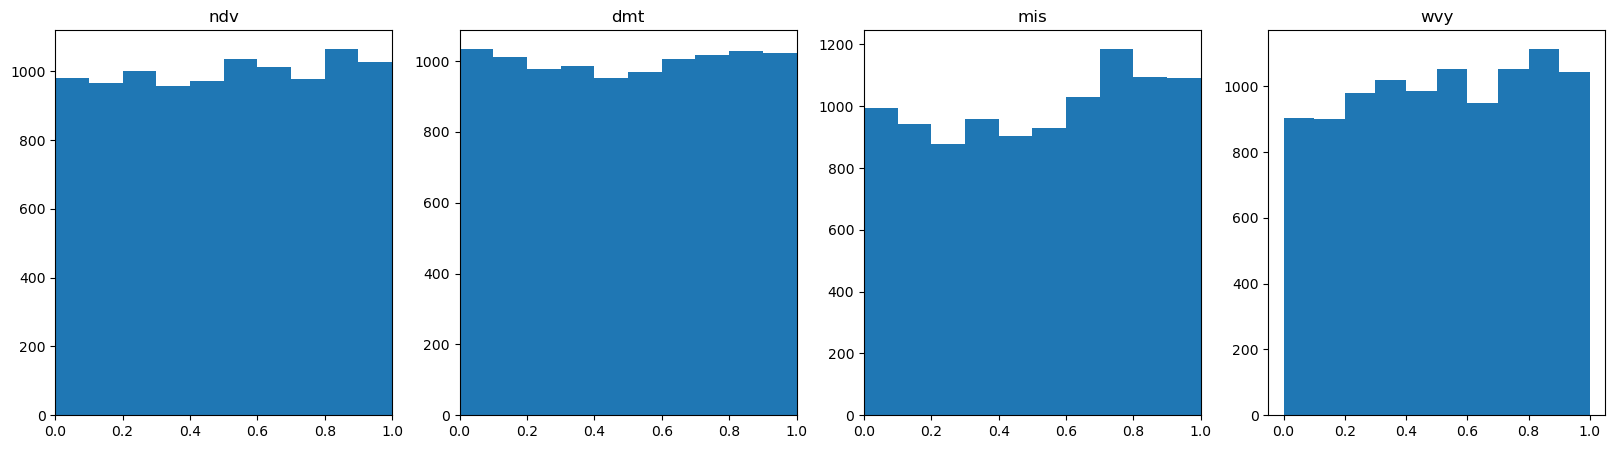

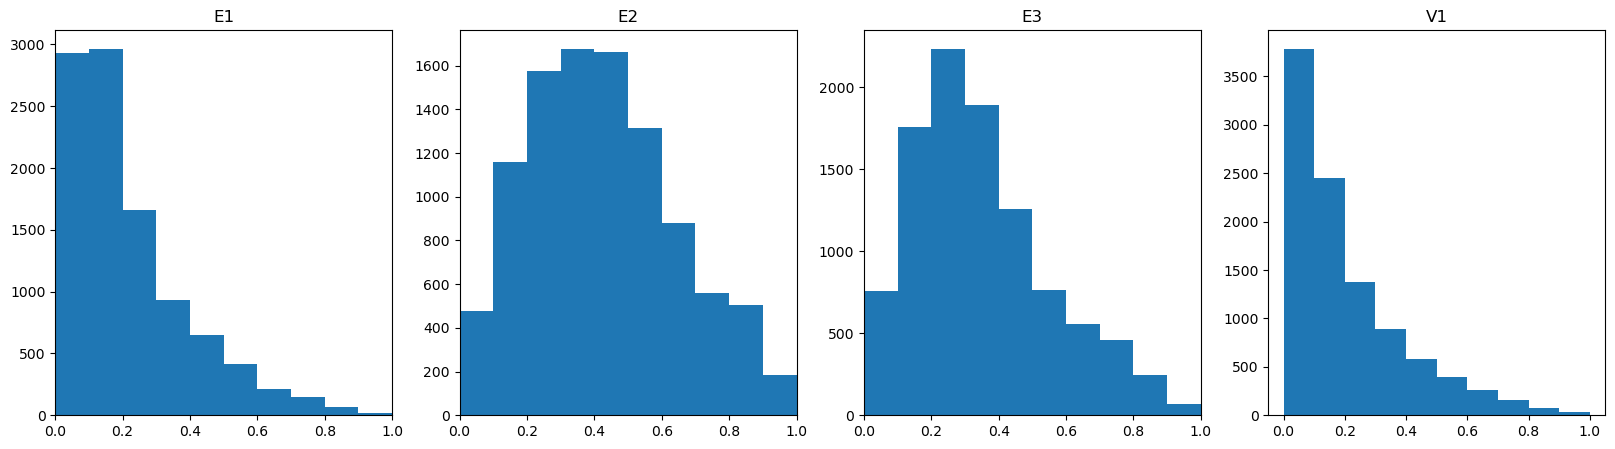

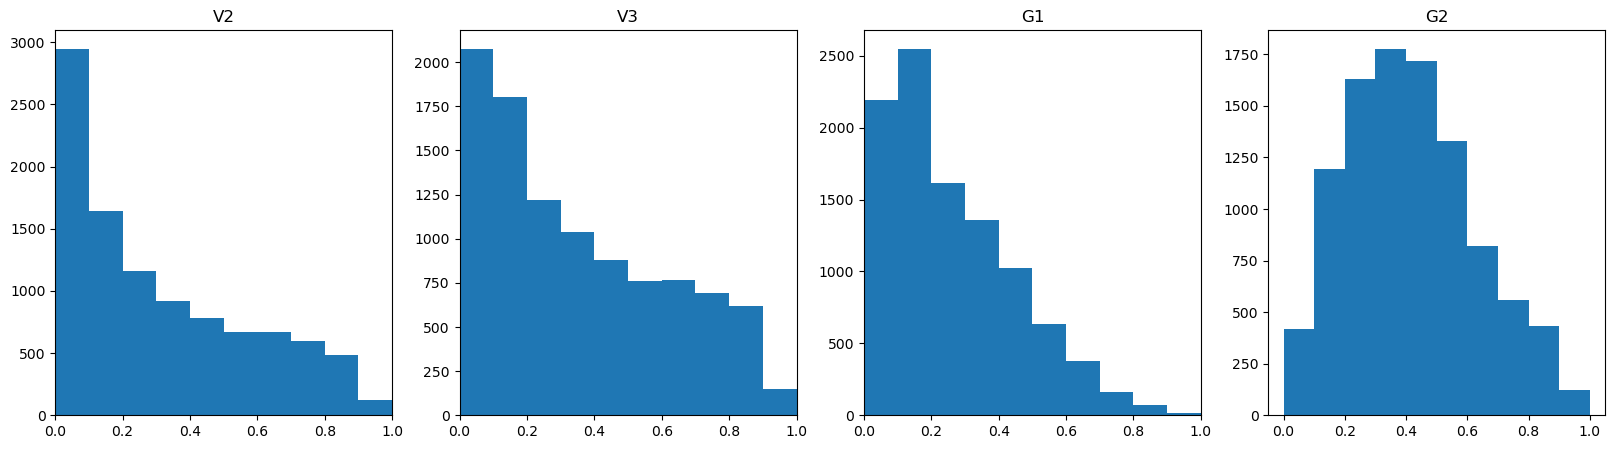

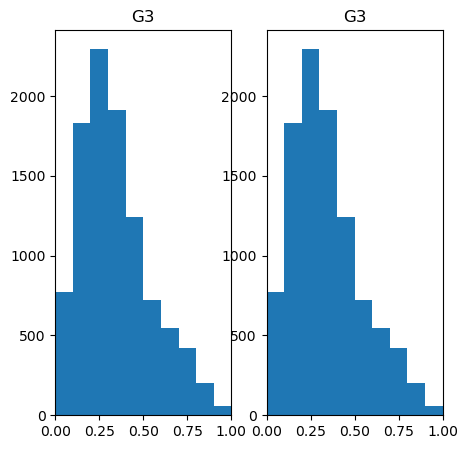

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].hist(train_norm[:,0].detach().numpy())
axes[0].set_title('ndv'); axes[0].set_xlim(0, 1)
axes[1].hist(train_norm[:,1].detach().numpy())
axes[1].set_title('dmt'); axes[1].set_xlim(0, 1)
axes[2].hist(train_norm[:,2].detach().numpy())
axes[2].set_title('mis'); axes[2].set_xlim(0, 1)
axes[3].hist(train_norm[:,3].detach().numpy())
axes[3].set_title('wvy'); axes[0].set_xlim(0, 1)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].hist(train_norm[:,4].detach().numpy())
axes[0].set_title(names[4]); axes[0].set_xlim(0, 1);
axes[1].hist(train_norm[:,5].detach().numpy())
axes[1].set_title(names[5]); axes[1].set_xlim(0, 1);
axes[2].hist(train_norm[:,6].detach().numpy())
axes[2].set_title(names[6]); axes[2].set_xlim(0, 1);
axes[3].hist(train_norm[:,7].detach().numpy())
axes[3].set_title(names[7]); axes[0].set_xlim(0, 1);

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].hist(train_norm[:,8].detach().numpy())
axes[0].set_title(names[8]); axes[0].set_xlim(0, 1);
axes[1].hist(train_norm[:,9].detach().numpy())
axes[1].set_title(names[9]); axes[1].set_xlim(0, 1);
axes[2].hist(train_norm[:,10].detach().numpy())
axes[2].set_title(names[10]); axes[2].set_xlim(0, 1);
axes[3].hist(train_norm[:,11].detach().numpy())
axes[3].set_title(names[11]); axes[0].set_xlim(0, 1);

fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist(train_norm[:,12].detach().numpy())
axes[0].set_title(names[12]); axes[0].set_xlim(0, 1);
axes[1].hist(S_train_norm[:,8].detach().numpy())  # This line shows the graphical representation, stating the train data file normalization
                                                  # and the S_train seperate normalization are one and the same
axes[1].set_title(names[12]); axes[1].set_xlim(0, 1);

Defining the input dimensions and latent dimensions

In [8]:
input_dim = 13

latent_dim = 6


The Architecture for the CVAE

In [9]:
class CVAE(torch.nn.Module):       
    def __init__(self):
        super().__init__()
        
       
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,256),      
            torch.nn.ReLU(),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,latent_dim+latent_dim),
            )
        self.decoder =  torch.nn.Sequential(
            torch.nn.Linear(latent_dim+S_train_norm.shape[1],256), # adding  a dynamic dimension concatenation so the decoder can dynamically adjust for the 
            torch.nn.ReLU(),                                       # changes in the decoder input dimensions
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,4),
            torch.nn.ReLU(),
            )

  
        
        
    def forward(self, encoder_in,S_train_norm):
        #encoding input: takes in only the encoder_in value(a concatenation of I and S)
        joint_mean_var = self.encoder(encoder_in)
        
        #seperating mean and variance
        z_mean = joint_mean_var[:,0:latent_dim]
        z_logvar = joint_mean_var[:,latent_dim:]
        
        # get standard deviation
        z_std = torch.sqrt(torch.exp(z_logvar))
        
        
        rows = encoder_in.shape[0]
        epsilon = torch.randn(rows,latent_dim) # the randn takes a normalized random value and creates epsilon tensor with dimensions(rows,latent_dim)
        z = z_mean + z_std*epsilon
        
        """ The decoder_in is the concatenation of the z values from the z space and the material properties"""
        decoder_in = torch.cat((z,S_train_norm),dim=1)
        #use the decoder to get I*(I_pred here is x_pred) from Z
        x_pred = self.decoder(decoder_in)

        # return
        return x_pred, z_mean, z_logvar, z

    def sample_from_latent_space(self,conditional_input): # Additional custom function to sample from latent space
        """ The sampling and distribution of the CVAE output is presumably created here. 
        Input: a tensor consisting of Mechanical properties of the 3 topologies are sent here.
                It can be of any length in dim 0, i.e can have any number of datasets.
                However, it must contain 9 features, 3x Youngs modulus, 3X Poisson's ratio and 3xShear Modulus'
        Purpose: Samples from the latent space based on the conditions provided here and generates Conditioned Imperfections
        Output: A distribution of tensors of size[Conditional_input_datapoints,4 kinds of Imperfections]"""
        # sample z from standard Gaussian/Normal distribution
        
        z = torch.randn(conditional_input.shape[0], latent_dim)
        

        # decode
        x_pred = self.decoder(torch.cat((z,conditional_input),dim=1))

        # return
        return x_pred

model =CVAE()
model

CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
    (7): ReLU()
  )
)

Code snippet for calculation of losses

In [10]:
"""The next function is calculation of the loss""" 
   
def calculate_loss(I_train_norm,I_pred,z_mean,z_logvar):
    # calculate N, to be used in estimated the KLD loss, which requires the number of datapoints
    N = I_train_norm.shape[0]
    
    #Beta, the KLD loss coefficient 
    beta = 0.5
    
    """First is the reconstruction loss. This directly takes into consideration how much the predicted value deviates from the original over
    every epoch"""
    #Loss function used : MSE loss
    MSE_loss = torch.nn.MSELoss()
    reconstruction_loss = (1-beta)*MSE_loss(I_pred,I_train_norm)
                                                                
    """The KLD loss calculation. This accounts for the deviation from a normal distribution that might be found in the latent space"""
    z_var = torch.exp(z_logvar)
    kld = 0.5*(z_var + z_mean**2 - 1 - z_logvar)
    kld_loss = 1.0/N * beta *torch.sum(kld)
    
    #The summation of both the losses
    total_loss = reconstruction_loss + kld_loss
    
    return total_loss, reconstruction_loss,kld_loss

The training cell for the NN 

In [11]:
"""The training of the model """
# a list of values for history
train_epoch_history  = []
train_loss_history = []     
train_reconstruction_loss_history = []
train_kld_loss_history = []

test_epoch_history = []
test_loss_history = []
test_reconstruction_loss_history = []
test_kld_loss_history = []  

#Learning Used in both the problems are 1e-3
lr = 0.001

#creating a variable for optimizer using Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#epoch creation
num_epoch = 2000
#calculation of time lapsed per set of epochs
print_interval = 100

start_time = time.time()
#iteration begins
for epoch in range(num_epoch):
    # a few lines of codes for time lapses
    if epoch%print_interval == 0:
        elapsed_time = time.time() - start_time
        elapsed_minutes = elapsed_time/60
        print(f'Epoch [{epoch}/{num_epoch}] - Elapsed minutes:{elapsed_minutes:.2f} minutes')
    
    """prediction using the model. Each prediction also provides the losses, which are iterated over time(epochs)"""
    I_pred,z_mean,z_logvar,z = model(encoder_in,S_train_norm) 
    # loss calculations
    total_loss, reconstruction_loss, kld_loss = calculate_loss(I_train_norm, I_pred, z_mean, z_logvar)
    
    #a few lines for storing histories
    train_epoch_history.append(epoch)
    train_loss_history.append(total_loss.detach().item())
    train_reconstruction_loss_history.append(reconstruction_loss.detach().item())
    train_kld_loss_history.append(kld_loss.detach().item())

    
    #using .backward() to compute the loss gradient
    total_loss.backward()
    
    
    optimizer.step()
    
    
    
    optimizer.zero_grad()
    
    
        
    with torch.no_grad():
        
        I_test_pred,z_mean,z_logvar,z = model(test_norm,S_test_norm)
        
        #losses
        total_loss, reconstruction_loss, kld_loss = calculate_loss(I_test_norm, I_test_pred, z_mean, z_logvar)
        
        test_epoch_history.append(epoch)
        test_loss_history.append(total_loss.detach().item())
        test_reconstruction_loss_history.append(reconstruction_loss.detach().item())
        test_kld_loss_history.append(kld_loss.detach().item())

Epoch [0/2000] - Elapsed minutes:0.00 minutes
Epoch [100/2000] - Elapsed minutes:0.17 minutes
Epoch [200/2000] - Elapsed minutes:0.32 minutes
Epoch [300/2000] - Elapsed minutes:0.48 minutes
Epoch [400/2000] - Elapsed minutes:0.63 minutes
Epoch [500/2000] - Elapsed minutes:0.79 minutes
Epoch [600/2000] - Elapsed minutes:0.95 minutes
Epoch [700/2000] - Elapsed minutes:1.10 minutes
Epoch [800/2000] - Elapsed minutes:1.26 minutes
Epoch [900/2000] - Elapsed minutes:1.41 minutes
Epoch [1000/2000] - Elapsed minutes:1.56 minutes
Epoch [1100/2000] - Elapsed minutes:1.71 minutes
Epoch [1200/2000] - Elapsed minutes:1.86 minutes
Epoch [1300/2000] - Elapsed minutes:2.01 minutes
Epoch [1400/2000] - Elapsed minutes:2.16 minutes
Epoch [1500/2000] - Elapsed minutes:2.32 minutes
Epoch [1600/2000] - Elapsed minutes:2.47 minutes
Epoch [1700/2000] - Elapsed minutes:2.62 minutes
Epoch [1800/2000] - Elapsed minutes:2.77 minutes
Epoch [1900/2000] - Elapsed minutes:2.93 minutes


<center>The Loss history plots</center>

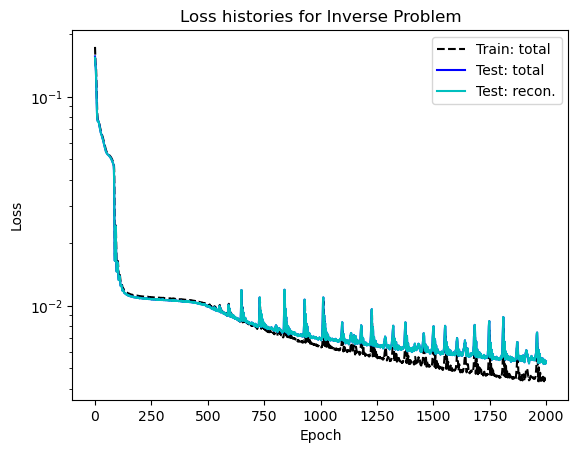

In [12]:
plt.plot(train_epoch_history, train_loss_history, "--k")
plt.plot(test_epoch_history, test_loss_history, "-b")
plt.plot(test_reconstruction_loss_history, "-c")
plt.legend(['Train: total', 'Test: total','Test: recon.'])
plt.yscale('log');
plt.xlabel('Epoch');

plt.ylabel('Loss');
plt.title('Loss histories for Inverse Problem');


A cell to plot and check for the distribution for a set of trained data. Just to have a visualized look at the data

E:\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

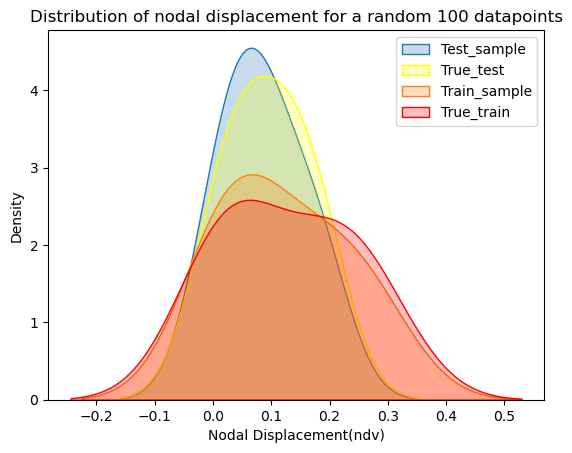

In [13]:
I_star_test= model.sample_from_latent_space(S_test_norm[100:200,:])
I_star_train = model.sample_from_latent_space(S_train_norm[100:200,:])


normalize.initialize(I_train)
I_star_test_rev = normalize.reverse_transform(I_star_test)

    
sb.kdeplot(I_star_test_rev.detach().numpy()[0],fill=True,label='Test_sample')
sb.kdeplot(I_test[100:200].detach().numpy()[0],fill=True,color='yellow',label='True_test')
I_star_train_rev = normalize.reverse_transform(I_star_train)

sb.kdeplot(I_star_train_rev.detach().numpy()[0],fill=True,label='Train_sample')
sb.kdeplot(I_train[100:200].detach().numpy()[0],fill=True,color='red',label='True_train')
plt.xlabel("Nodal Displacement(ndv)")
plt.title('Distribution of nodal displacement for a random 100 datapoints')
plt.legend()

A Cell to make predictions using test data

In [23]:

with torch.no_grad():
    new_pred,new_zmean,new_zlogvar,new_z = model(test_norm,S_test_norm)
    total_loss_new, reconstruction_loss_new, kld_loss_new = calculate_loss(I_test_norm, I_test_pred, z_mean, z_logvar)

new_pred_reversed = normalize.reverse_transform(new_pred)

I_test_reversed = normalize.reverse_transform(I_test_norm)


<center>Accuracy determination using R2 method</center>

In [15]:
"""Calculation of R2"""
def calculate_R2(true, pred):
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)

def plotR2_stiffness(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([-1,true[:,index].max()],[-1,true[:,index].max()],c='red')
        ax.set_title('C: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(3, 3, i+1)
        helper(ax,i)
    fig.tight_layout()

def plotR2_design(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    labels = ['Node deviation (ndv)','Diameter deviation (dmt)','Missing beams (mis)','Wavy beams (wvy)']
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].numpy(), pred[:,index].detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach(),c='blue')
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()],c='red')
        ax.set_title('{},  R2={}'.format(labels[index],R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(2, 2, i+1)
        helper(ax,i)
    fig.tight_layout()


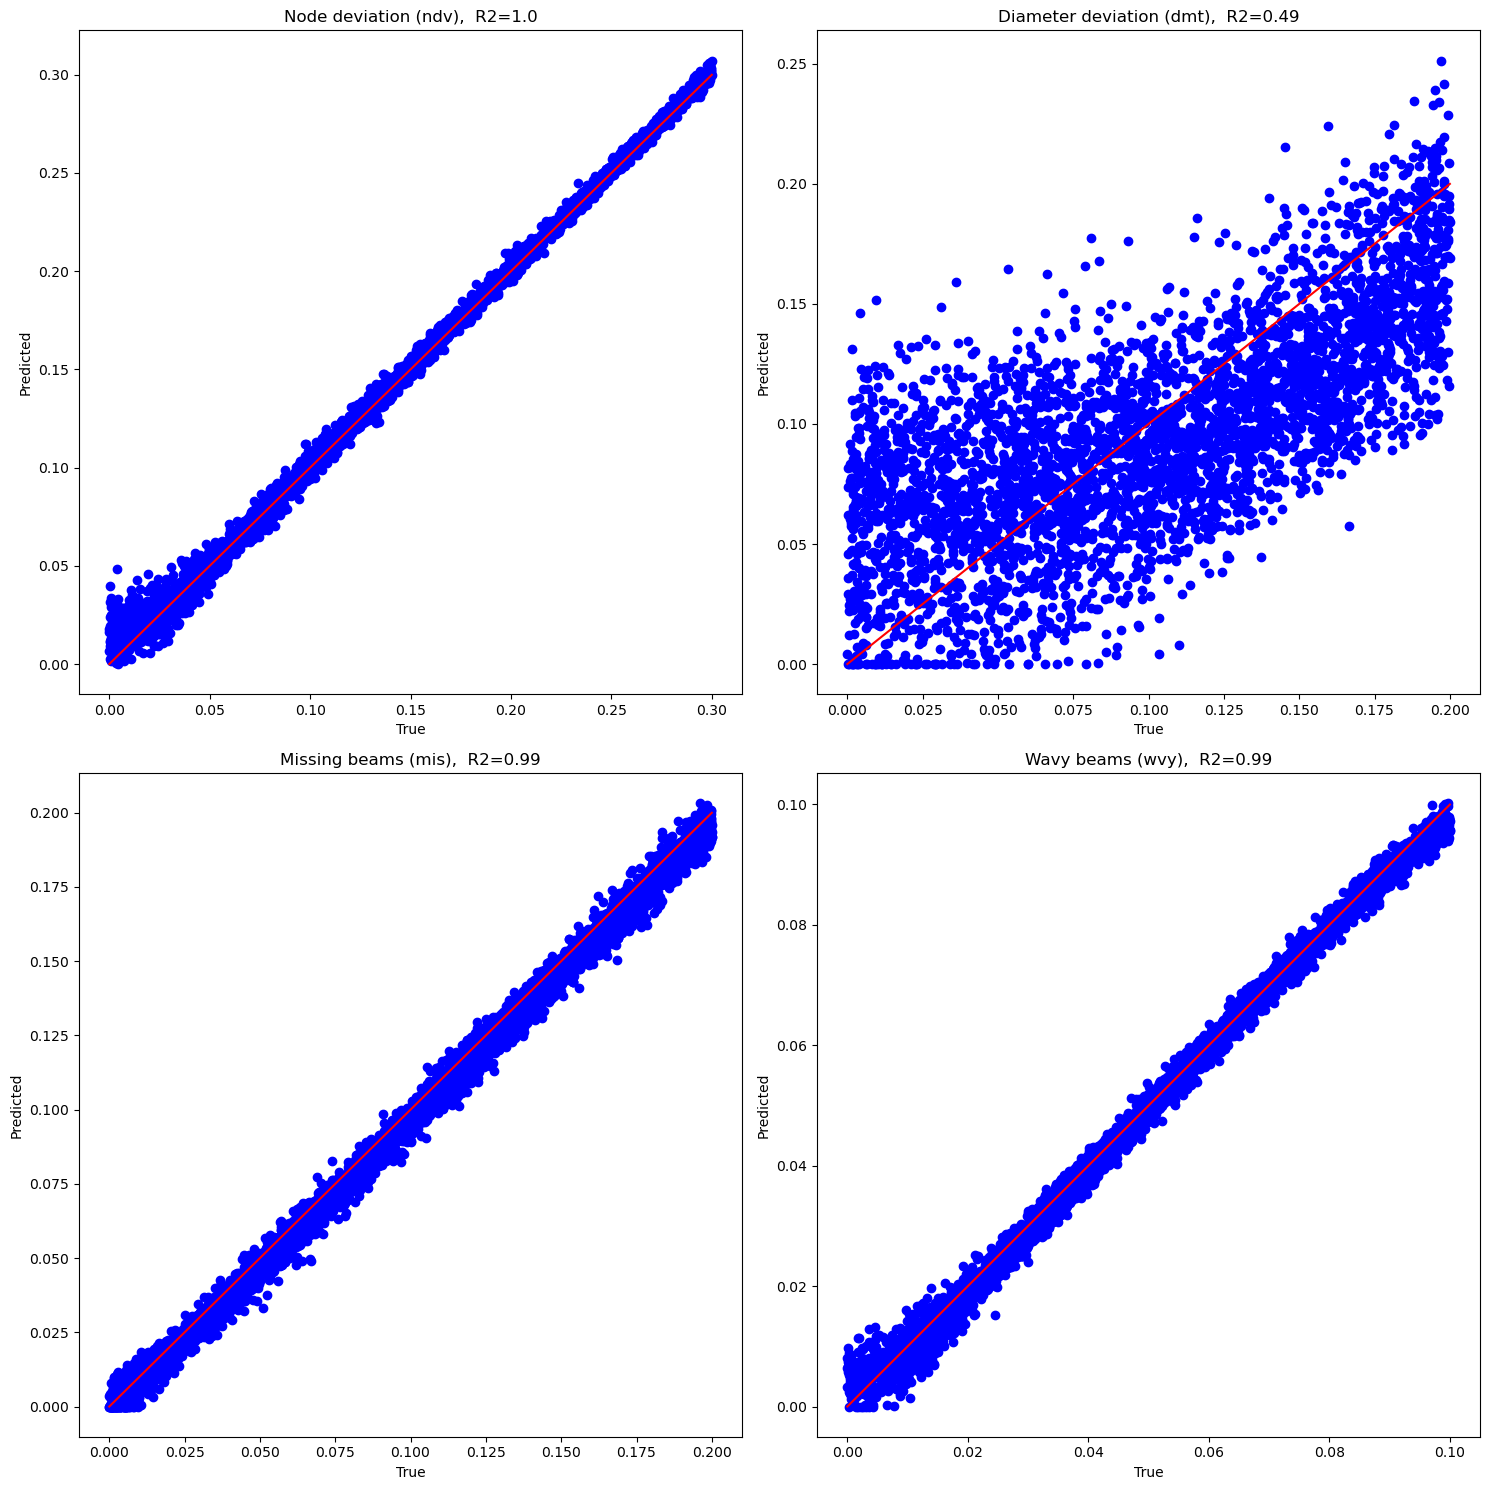

In [16]:

plotR2_design(I_test_reversed, normalize.reverse_transform(I_test_pred))
I_pred_reversed = normalize.reverse_transform(I_pred)


Next part is the calculation for marginal probabilities. This cell provides tries to show how each marginalized feature taken into consideration(for this problem, the Imperfections
) is distributed over the entire dataset

In [24]:
# Calculate the expectation of the marginal probabilities (approximated by the mean)
E_ndv = torch.mean(I_pred_reversed[:, 0]).detach().item()
E_dmt = torch.mean(I_pred_reversed[:, 1]).detach().item()
E_mis = torch.mean(I_pred_reversed[:, 2]).detach().item()
E_wvy = torch.mean(I_pred_reversed[:, 3]).detach().item()
E = [E_ndv, E_dmt, E_mis, E_wvy]


E_ndv_true = torch.mean(I_train[:, 0]).detach().item()
E_dmt_true = torch.mean(I_train[:, 1]).detach().item()
E_mis_true = torch.mean(I_train[:, 2]).detach().item()
E_wvy_true = torch.mean(I_train[:, 3]).detach().item()
true_values_np = [E_ndv_true, E_dmt_true, E_mis_true, E_wvy_true]


ndv_std = torch.std(I_pred_reversed[:, 0]).detach().item()
dmt_std = torch.std(I_pred_reversed[:, 1]).detach().item()
mid_std = torch.std(I_pred_reversed[:, 2]).detach().item()
wvy_std = torch.std(I_pred_reversed[:, 3]).detach().item()

The next cell plots the marginal probability distribution

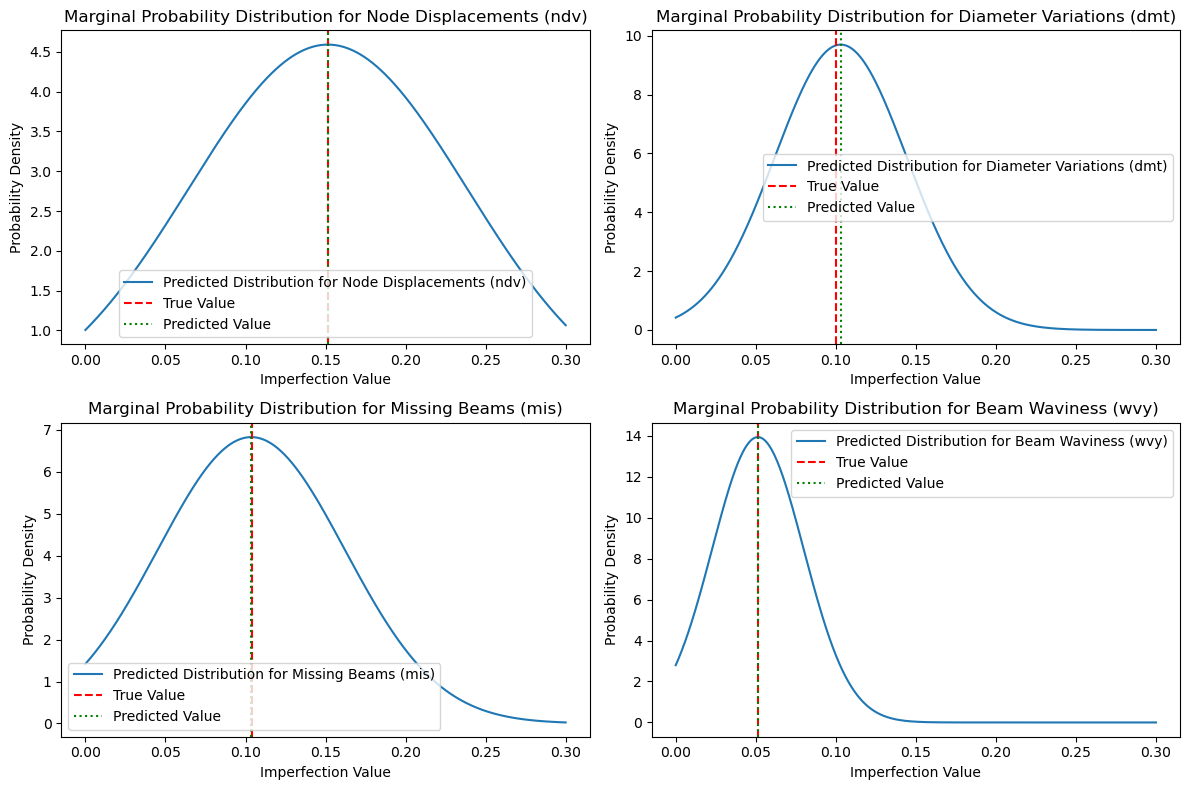

In [18]:
x = np.linspace(0, 0.3, 1000)
keys = ["Node Displacements (ndv)", "Diameter Variations (dmt)", "Missing Beams (mis)", "Beam Waviness (wvy)"]
distributions = {
    keys[0]: norm.pdf(x, loc=E[0], scale=ndv_std),
    keys[1]: norm.pdf(x, loc=E[1], scale=dmt_std),
    keys[2]: norm.pdf(x, loc=E[2], scale=mid_std),
    keys[3]: norm.pdf(x, loc=E[3], scale=wvy_std),
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, key in enumerate(keys):
    ax = axes[i]
    ax.plot(x, distributions[key], label=f'Predicted Distribution for {key}')
    ax.axvline(true_values_np[i], color='r', linestyle='--', label='True Value')
    ax.axvline(E[i], color='g', linestyle=':', label='Predicted Value')
    ax.set_title(f'Marginal Probability Distribution for {key}')
    ax.set_xlabel('Imperfection Value')
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.tight_layout()
plt.show()

The upcoming cells create the marginal probability distribution for a specific cases of data points, as seen above. To elaborate further, a specific data point containing a set of 
mechanical properties is used to create a distribution of Imperfections and these are marginalized and plotted over to see the marginal distribution.

In [26]:
plot_I_true = I_test[9:10,:]

S_input_sample = S_test_norm[9:10,:]

tens_out = torch.zeros(30,4)
for i in range(30):
    tens_out[i] = model.sample_from_latent_space(S_test_norm[9:10,:])

normalize.initialize(I_test)
tens_out = normalize.reverse_transform(tens_out
                                       )
# Calculate the expectation of the marginal probabilities (approximated by the mean)
E_ndv = torch.mean(tens_out[:, 0]).detach().item()
E_dmt = torch.mean(tens_out[:, 1]).detach().item()
E_mis = torch.mean(tens_out[:, 2]).detach().item()
E_wvy = torch.mean(tens_out[:, 3]).detach().item()
E = [E_ndv, E_dmt, E_mis, E_wvy]


 
E_ndv_true = I_test[9:10,0].numpy()
E_dmt_true = I_test[9:10,1].numpy()
E_mis_true = I_test[9:10,2].numpy()
E_wvy_true = I_test[9:10,3].numpy()
true_values_np = [E_ndv_true, E_dmt_true, E_mis_true, E_wvy_true]


ndv_std = torch.std(tens_out[:, 0]).detach().item()
dmt_std = torch.std(tens_out[:, 1]).detach().item()
mid_std = torch.std(tens_out[:, 2]).detach().item()
wvy_std = torch.std(tens_out[:, 3]).detach().item()


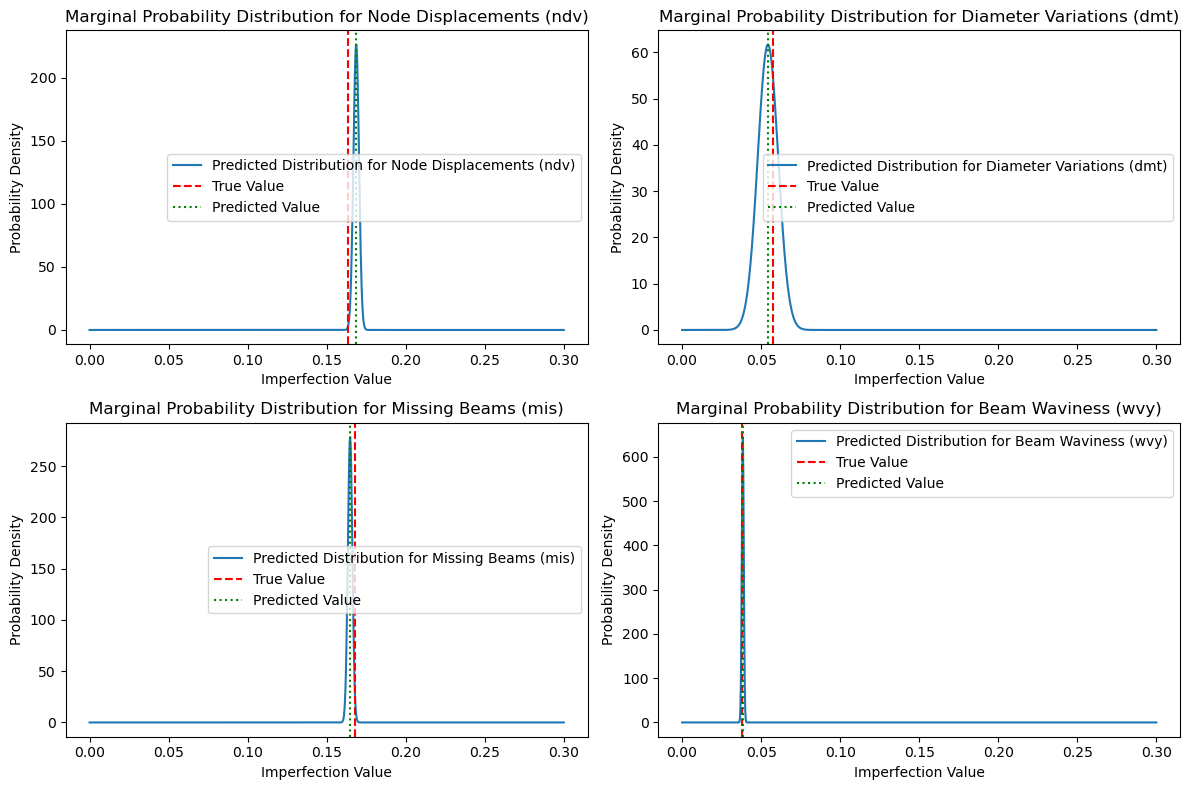

In [20]:
x = np.linspace(0, 0.3, 1000)
keys = ["Node Displacements (ndv)", "Diameter Variations (dmt)", "Missing Beams (mis)", "Beam Waviness (wvy)"]
distributions = {
    keys[0]: norm.pdf(x, loc=E[0], scale=ndv_std),
    keys[1]: norm.pdf(x, loc=E[1], scale=dmt_std),
    keys[2]: norm.pdf(x, loc=E[2], scale=mid_std),
    keys[3]: norm.pdf(x, loc=E[3], scale=wvy_std),
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, key in enumerate(keys):
    ax = axes[i]
    ax.plot(x, distributions[key], label=f'Predicted Distribution for {key}')
    ax.axvline(true_values_np[i], color='r', linestyle='--', label='True Value')
    ax.axvline(E[i], color='g', linestyle=':', label='Predicted Value')
    ax.set_title(f'Marginal Probability Distribution for {key}')
    ax.set_xlabel('Imperfection Value')
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.tight_layout()
plt.show()

<center><h1><span style="color: red;">This marks the end of the Inverse Problem</span></h1></center>

<h1><center><strong>Working Codes for The Forward Problem</strong></center></h1>

The codes for the forward problem are written in a similar manner to the Inverse problem. 

In [28]:
class CVAE(torch.nn.Module):       
    def __init__(self):
        super().__init__()
        
       
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,256),       
            torch.nn.ReLU(),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,latent_dim+latent_dim),
            )
        self.decoder =  torch.nn.Sequential(
            torch.nn.Linear(latent_dim+I_train_norm.shape[1],256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,9),
            torch.nn.ReLU(),
            )
     
 
        
    def forward(self, encoder_in,I_train_norm):
        #encoding input: takes in only the encoder_in value(a concatenation of I and S)
        joint_mean_var = self.encoder(encoder_in)
        
        #seperating mean and variance
        z_mean = joint_mean_var[:,0:latent_dim]
        z_logvar = joint_mean_var[:,latent_dim:]
        
        # get standard deviation
        z_std = torch.sqrt(torch.exp(z_logvar))
        
        
        rows = encoder_in.shape[0]
        epsilon = torch.randn(rows,latent_dim) # the randn takes a normalized random value and creates epsilon tensor with dimensions(rows,latent_dim)
        z = z_mean + z_std*epsilon
        
        
        decoder_in = torch.cat((z,I_train_norm),dim=1)
        #use the decoder to get I*(I_pred here is x_pred) from Z
        x_pred = self.decoder(decoder_in)

        # return
        return x_pred, z_mean, z_logvar, z

    def sample_from_latent_space(self,conditional_input): # Additional custom function to sample from latent space
        """ The sampling and distribution of the CVAE output is presumably created here. 
        Input: a tensor consisting of Mechanical properties of the 3 topologies are sent here.
                It can be of any length in dim 0, i.e can have any number of datasets.
                However, it must contain 9 features, 3x Youngs modulus, 3X Poisson's ratio and 3xShear Modulus'
        Purpose: Samples from the latent space based on the conditions provided here and generates Conditioned Imperfections
        Output: A distribution of tensors of size[Conditional_input_datapoints,4 kinds of Imperfections]"""
        # sample z from standard Gaussian/Normal distribution
        
        z = torch.randn(conditional_input.shape[0], latent_dim)
        

        # decode
        x_pred = self.decoder(torch.cat((z,conditional_input),dim=1))

        # return
        return x_pred

model =CVAE()
model  

CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=9, bias=True)
    (7): ReLU()
  )
)

In [29]:
def calculate_loss(S_train_norm,S_pred,z_mean,z_logvar):
        # calculate N, to be used in estimated the KLD loss, which requires the number of datapoints
        N = S_train_norm.shape[0]
        
        #Beta, the KLD loss coefficient 
        beta = 0.5
        
        """First is the reconstruction loss. This directly takes into consideration how much the predicted value deviates from the original over
        every epoch"""
        #Loss function used : MSE loss
        MSE_loss = torch.nn.MSELoss()
        reconstruction_loss = (1-beta)*MSE_loss(S_pred,S_train_norm)
                                                                    
                                                                    
        """The KLD loss calculation. This accounts for the deviation from a normal distribution that might be found in the latent space"""
        z_var = torch.exp(z_logvar)
        kld = 0.5*(z_var + z_mean**2 - 1 - z_logvar)
        kld_loss = 1.0/N * beta *torch.sum(kld)
        
        #The summation of both the losses
        total_loss = reconstruction_loss + kld_loss
        
        return total_loss, reconstruction_loss,kld_loss

In [30]:
train_epoch_history  = []
train_loss_history = []     
train_reconstruction_loss_history = []
train_kld_loss_history = []

test_epoch_history = []
test_loss_history = []
test_reconstruction_loss_history = []
test_kld_loss_history = []  

# defining the learning rate as 1e-3
lr = 0.001

#creating a variable for optimizer using Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#epoch creation
num_epoch = 2000
#calculation of time lapsed per set of epochs
print_interval = 100

start_time = time.time()
#iteration begins
for epoch in range(num_epoch):
    # a few lines of codes for time lapses
    if epoch%print_interval == 0:
        elapsed_time = time.time() - start_time
        elapsed_minutes = elapsed_time/60
        print(f'Epoch [{epoch}/{num_epoch}] - Elapsed minutes:{elapsed_minutes:.2f} minutes')
    
    """prediction using the model. Each prediction also provides the losses, which are iterated over time(epochs)"""
    S_pred,z_mean,z_logvar,z = model(encoder_in,I_train_norm) 
    
    # loss calculations
    total_loss, reconstruction_loss, kld_loss = calculate_loss(S_train_norm, S_pred, z_mean, z_logvar)
    
    #a few lines for storing histories
    train_epoch_history.append(epoch)
    train_loss_history.append(total_loss.detach().item())
    train_reconstruction_loss_history.append(reconstruction_loss.detach().item())
    train_kld_loss_history.append(kld_loss.detach().item())

    
    #using .backward() to compute the loss gradient
    total_loss.backward()
    
    optimizer.step()
    
    
    optimizer.zero_grad()
    
    
        
    with torch.no_grad():
        
        S_test_pred,z_mean,z_logvar,z = model(test_norm,I_test_norm)
        
        #losses
        total_loss, reconstruction_loss, kld_loss = calculate_loss(S_test_norm, S_test_pred, z_mean, z_logvar)
        
        test_epoch_history.append(epoch)
        test_loss_history.append(total_loss.detach().item())
        test_reconstruction_loss_history.append(reconstruction_loss.detach().item())
        test_kld_loss_history.append(kld_loss.detach().item())
        

Epoch [0/2000] - Elapsed minutes:0.00 minutes
Epoch [100/2000] - Elapsed minutes:0.18 minutes
Epoch [200/2000] - Elapsed minutes:0.33 minutes
Epoch [300/2000] - Elapsed minutes:0.48 minutes
Epoch [400/2000] - Elapsed minutes:0.65 minutes
Epoch [500/2000] - Elapsed minutes:0.81 minutes
Epoch [600/2000] - Elapsed minutes:0.96 minutes
Epoch [700/2000] - Elapsed minutes:1.14 minutes
Epoch [800/2000] - Elapsed minutes:1.30 minutes
Epoch [900/2000] - Elapsed minutes:1.46 minutes
Epoch [1000/2000] - Elapsed minutes:1.62 minutes
Epoch [1100/2000] - Elapsed minutes:1.79 minutes
Epoch [1200/2000] - Elapsed minutes:1.96 minutes
Epoch [1300/2000] - Elapsed minutes:2.14 minutes
Epoch [1400/2000] - Elapsed minutes:2.30 minutes
Epoch [1500/2000] - Elapsed minutes:2.46 minutes
Epoch [1600/2000] - Elapsed minutes:2.63 minutes
Epoch [1700/2000] - Elapsed minutes:2.80 minutes
Epoch [1800/2000] - Elapsed minutes:2.96 minutes
Epoch [1900/2000] - Elapsed minutes:3.11 minutes


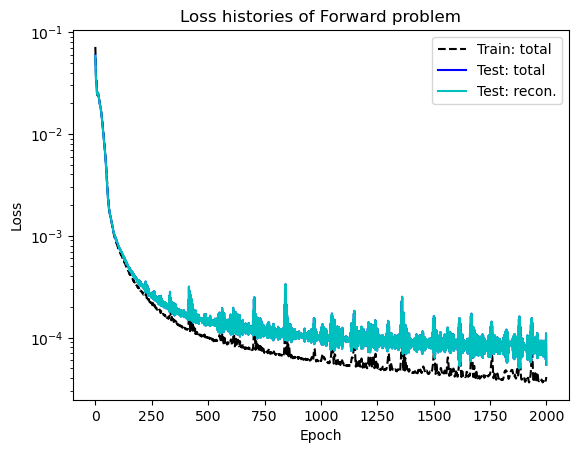

In [31]:

plt.plot(train_epoch_history, train_loss_history, "--k")
plt.plot(test_epoch_history, test_loss_history, "-b")
plt.plot(test_reconstruction_loss_history, "-c")
plt.legend(['Train: total', 'Test: total','Test: recon.'])
plt.yscale('log');
plt.xlabel('Epoch');

plt.ylabel('Loss');
plt.title('Loss histories of Forward problem');


E:\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

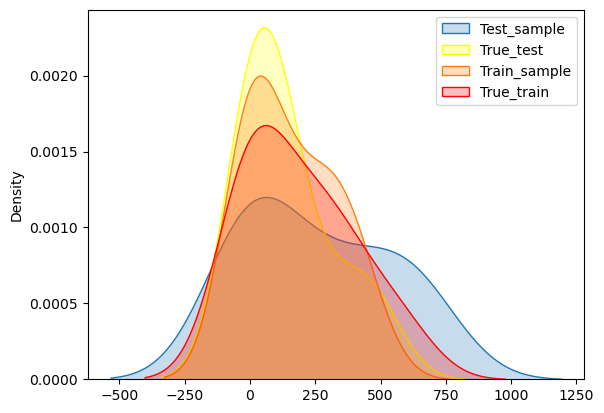

In [32]:
S_star_test= model.sample_from_latent_space(I_test_norm[1800:2200,:])
S_star_train = model.sample_from_latent_space(I_train_norm[1800:2200,:])


normalize.initialize(S_train)
S_star_test_rev = normalize.reverse_transform(S_star_test)


sb.kdeplot(S_star_test_rev.detach().numpy()[0],fill=True,label='Test_sample')
S_star_train_rev = normalize.reverse_transform(S_star_train)
sb.kdeplot(S_test[100:200].detach().numpy()[0],fill=True,color='yellow',label='True_test')
sb.kdeplot(S_star_train_rev.detach().numpy()[0],fill=True,label='Train_sample')
sb.kdeplot(S_train[100:200].detach().numpy()[0],fill=True,color='red',label='True_train')

plt.legend() 


In [33]:
with torch.no_grad():
    new_pred,new_zmean,new_zlogvar,new_z = model(test_norm,I_test_norm)
    total_loss_new, reconstruction_loss_new, kld_loss_new = calculate_loss(S_test_norm, new_pred, z_mean, z_logvar)
   
normalize.initialize(S_test)
new_pred_reversed = normalize.reverse_transform(new_pred)

S_test_reversed = normalize.reverse_transform(S_test_norm)

Calculation of R2

In [34]:
def calculate_R2(true, pred):
# Note: both true and pred should be numpy 1D-array, NOT torch tensors
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)

def plotR2_stiffness(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    labels = ['E1','E2','E3','v1','v2','v3','G1','G2','G3']
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].numpy(), pred[:,index].detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([true[:,index].min(),true[:,index].max()],[true[:,index].min(),true[:,index].max()],c='red')
        ax.set_title('{},  R2={}'.format(labels[index],R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(3, 3, i+1)
        helper(ax,i)
    fig.tight_layout()

def plotR2_design(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    labels = ['Node deviation (ndv)','Diameter deviation (dmt)','Missing beams (mis)','Wavy beams (wvy)']
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].numpy(), pred[:,index].detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach(),c='blue')
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()],c='red')
        ax.set_title('{},  R2={}'.format(labels[index],R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(2, 2, i+1)
        helper(ax,i)
    fig.tight_layout()


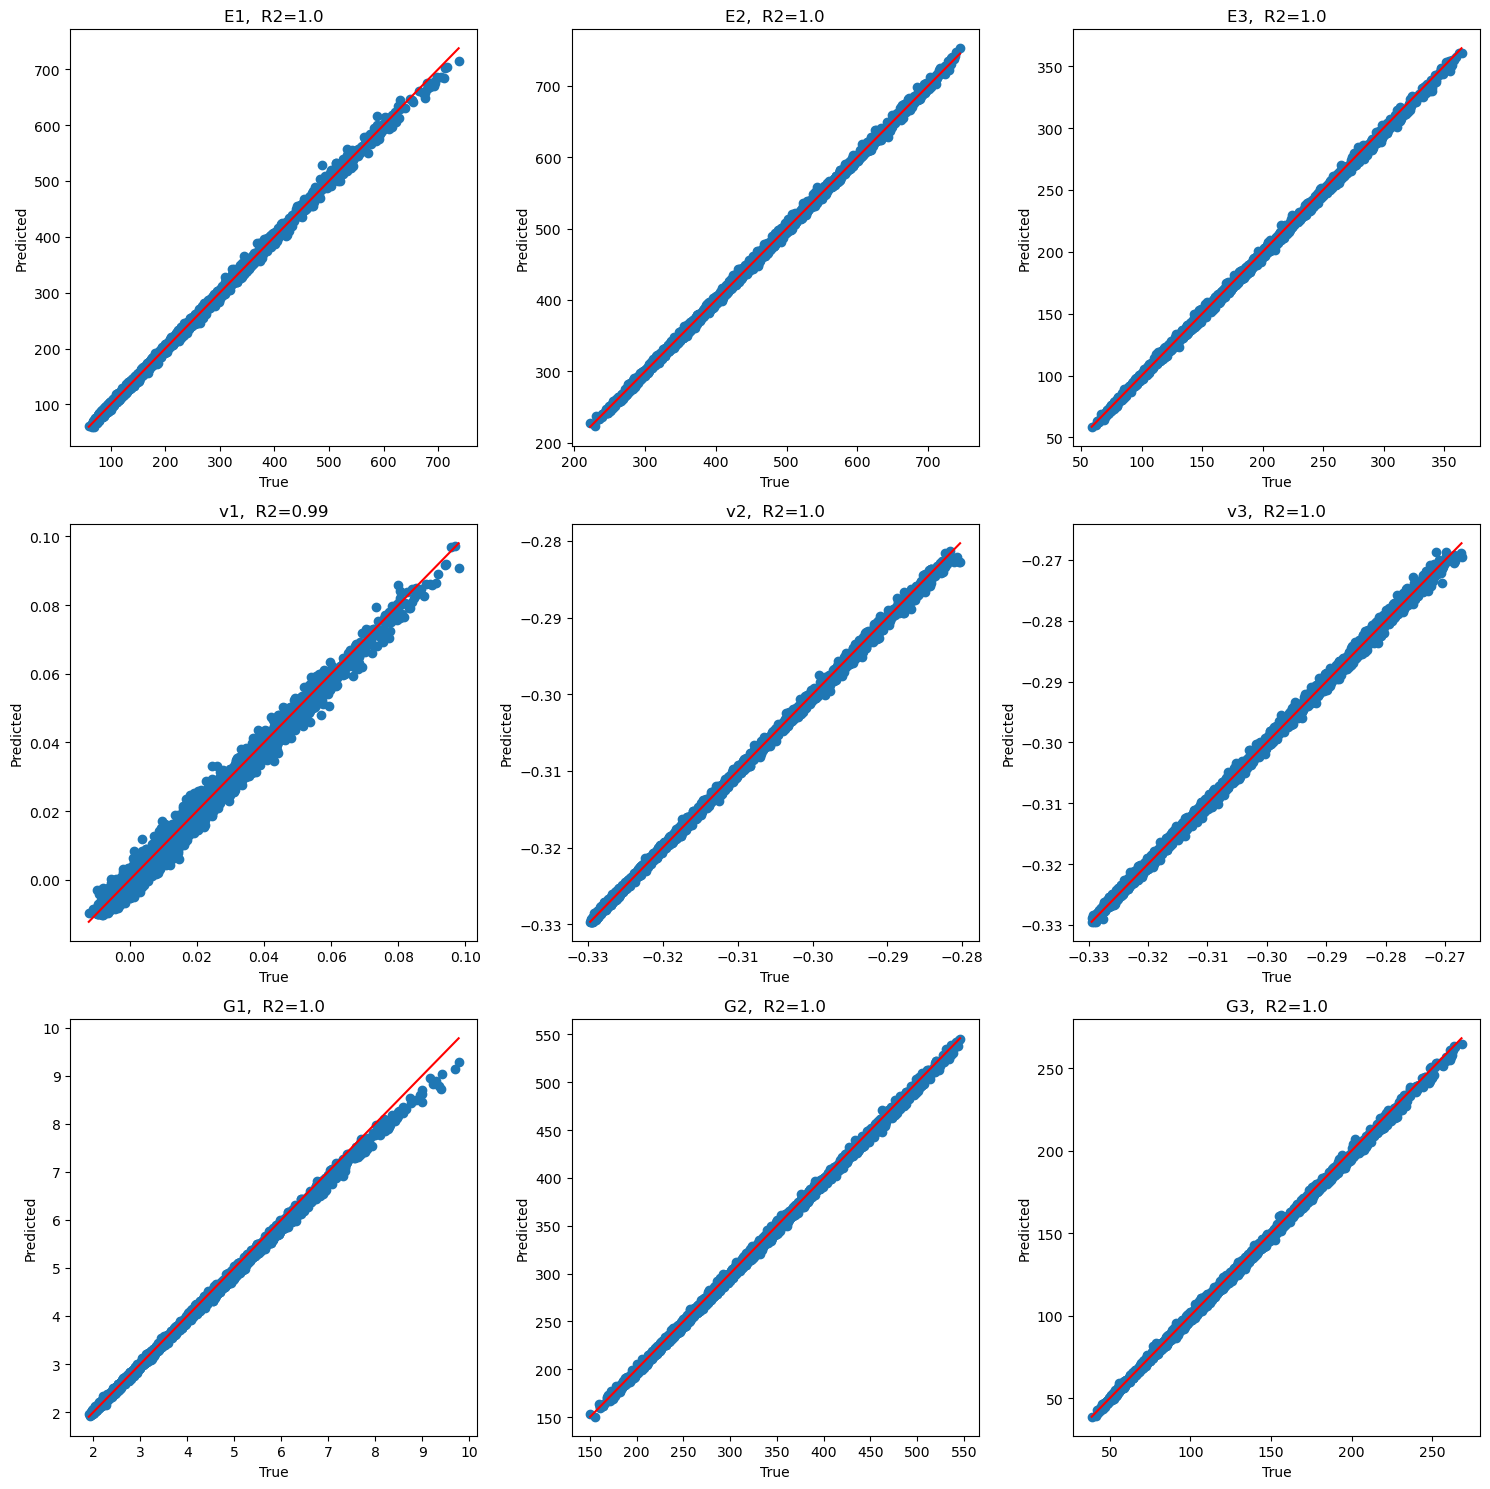

In [35]:

plotR2_stiffness(S_test_reversed, normalize.reverse_transform(S_test_pred))
S_pred_reversed = normalize.reverse_transform(S_pred)


In [36]:
# Calculate the expectation of the marginal probabilities (approximated by the mean)
E1 = torch.mean(S_pred_reversed[:, 0]).detach().item()
E2 = torch.mean(S_pred_reversed[:, 1]).detach().item()
E3 = torch.mean(S_pred_reversed[:, 2]).detach().item()
v1 = torch.mean(S_pred_reversed[:, 3]).detach().item()
v2 = torch.mean(S_pred_reversed[:, 4]).detach().item()
v3 = torch.mean(S_pred_reversed[:, 5]).detach().item()
G1 = torch.mean(S_pred_reversed[:, 6]).detach().item()
G2 = torch.mean(S_pred_reversed[:, 7]).detach().item()
G3 = torch.mean(S_pred_reversed[:, 8]).detach().item()    
S = [E1,E2,E3,v1,v2,v3,G1,G2,G3]

E1_true = torch.mean(S_train[:, 0]).detach().item()
E2_true = torch.mean(S_train[:, 1]).detach().item()
E3_true = torch.mean(S_train[:, 2]).detach().item()
v1_true = torch.mean(S_train[:, 3]).detach().item()
v2_true = torch.mean(S_train[:, 4]).detach().item()
v3_true = torch.mean(S_train[:, 5]).detach().item()
G1_true = torch.mean(S_train[:, 6]).detach().item()
G2_true = torch.mean(S_train[:, 7]).detach().item()
G3_true = torch.mean(S_train[:, 8]).detach().item()
true_values_np = [E1_true,E2_true,E3_true,v1_true,v2_true,v2_true,G1_true,
                  G2_true,G3_true]

E1_std = torch.std(S_pred_reversed[:, 0]).detach().item()
E2_std = torch.std(S_pred_reversed[:, 1]).detach().item()
E3_std = torch.std(S_pred_reversed[:, 2]).detach().item()
v1_std = torch.std(S_pred_reversed[:, 3]).detach().item()
v2_std = torch.std(S_pred_reversed[:, 4]).detach().item()
v3_std = torch.std(S_pred_reversed[:, 5]).detach().item()
G1_std = torch.std(S_pred_reversed[:, 6]).detach().item()
G2_std = torch.std(S_pred_reversed[:, 7]).detach().item()
G3_std = torch.std(S_pred_reversed[:, 8]).detach().item()

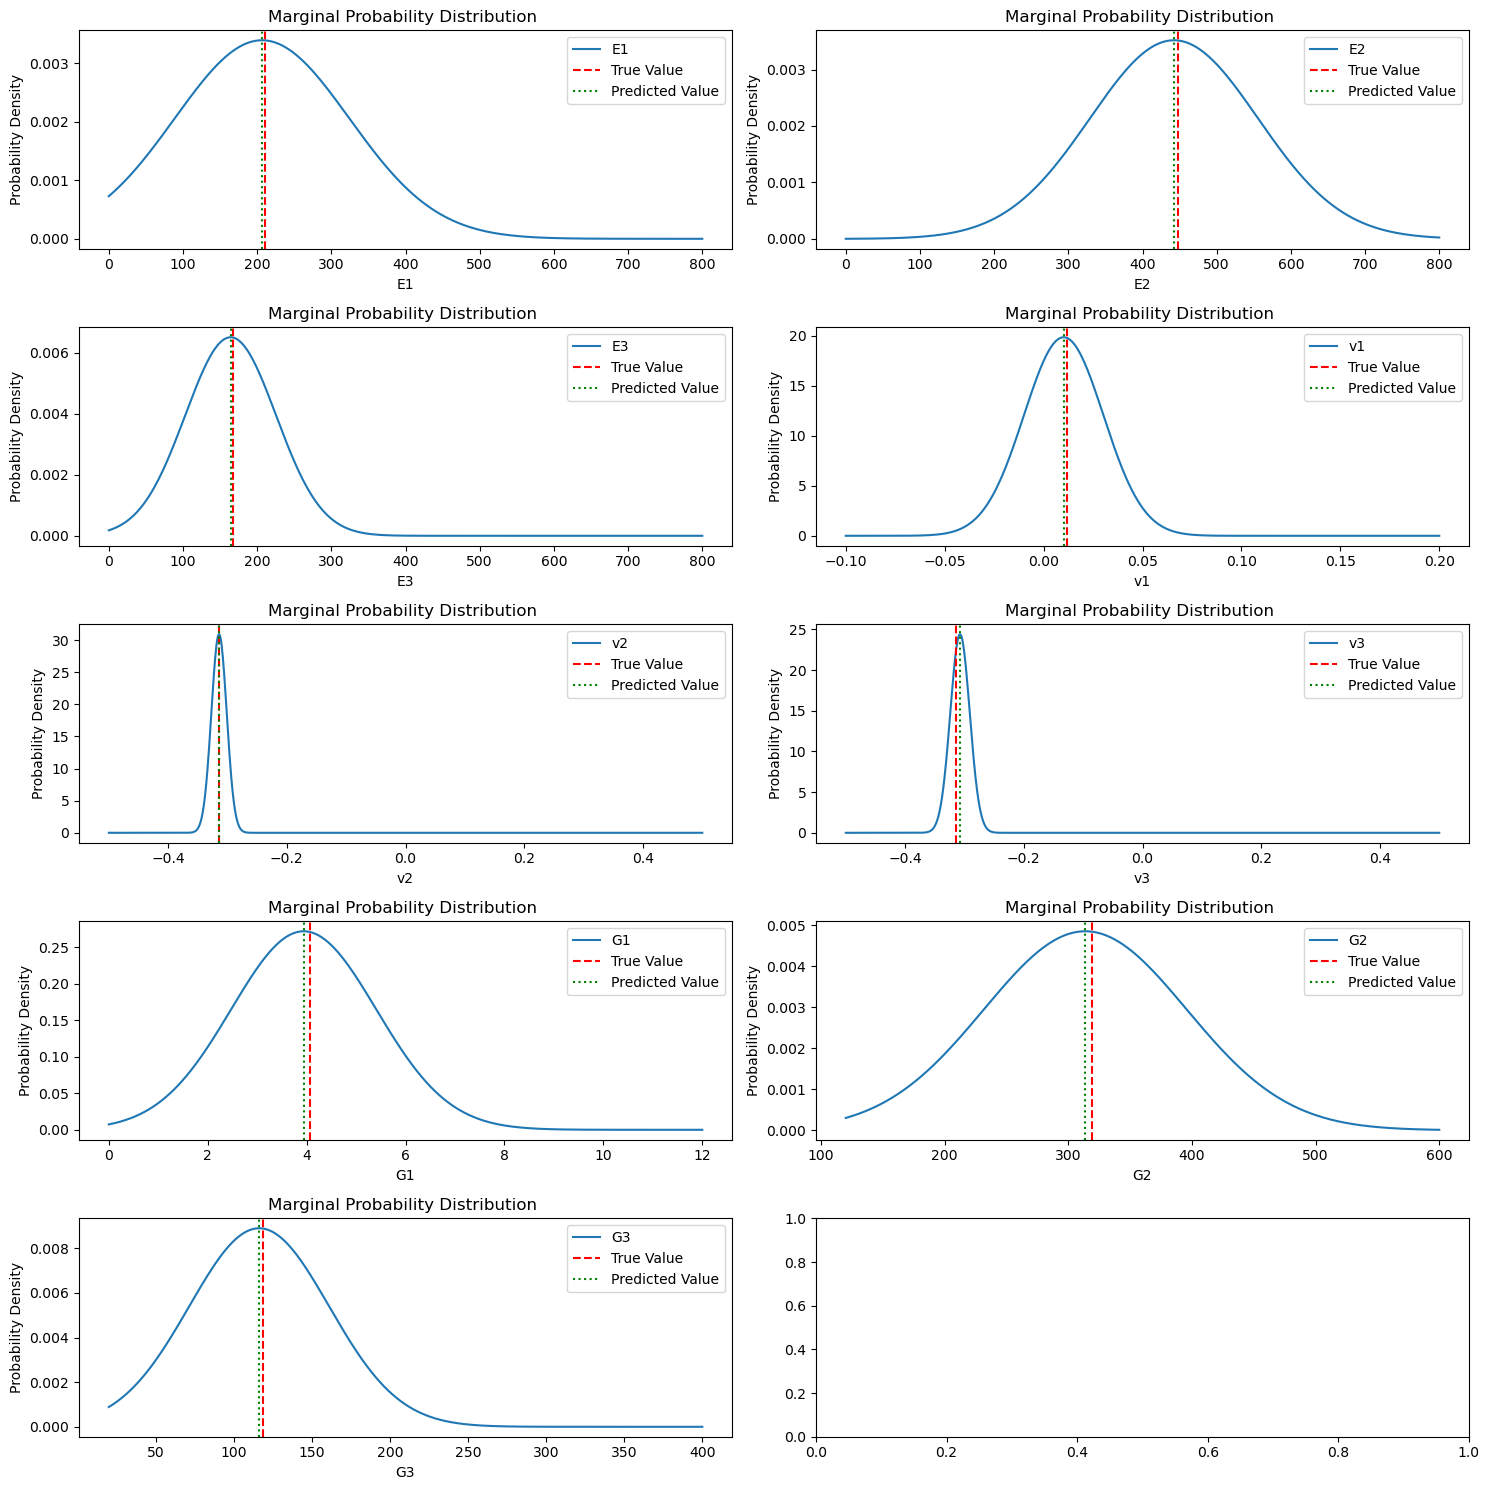

In [37]:
key = ['E1','E2','E3','v1','v2','v3','G1','G2','G3']
std_list = [E1_std,E2_std,E3_std,v1_std,v2_std,v3_std,G1_std,G2_std,G3_std]
x = [np.linspace(0,800,1000),np.linspace(0,800,1000),np.linspace(0,800,1000),
     np.linspace(-0.1,0.2,1000),np.linspace(-0.5,0.5,1000),np.linspace(-0.5,0.5,1000),
     np.linspace(0,12,1000),np.linspace(120,600,1000),np.linspace(20,400,1000)]
distributions = {}
for i,pdf in enumerate(key):
    distributions[key[i]] = norm.pdf(x[i], loc=S[i], scale=std_list[i])
   

# Plotting
fig, axes = plt.subplots(5,2 , figsize=(15, 15))
axes = axes.flatten()

for i, keys in enumerate(key):
    ax = axes[i]
    ax.plot(x[i], distributions[keys], label = f'{key[i]}' )
    ax.axvline(true_values_np[i], color='r', linestyle='--', label='True Value')
    ax.axvline(S[i], color='g', linestyle=':', label='Predicted Value')
    ax.set_title('Marginal Probability Distribution ')
    ax.set_xlabel(f'{key[i]}')
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.tight_layout()

plt.show()



In [38]:
plot_S_true = S_test[9:10,:]


I_input_sample = I_test_norm[9:10,:]

tens_out = torch.zeros(100,9)
for i in range(100):
    tens_out[i] = model.sample_from_latent_space(I_test_norm[9:10,:])

normalize.initialize(S_test)
tens_out = normalize.reverse_transform(tens_out
                                       )
E1 = torch.mean(tens_out[:, 0]).detach().item()
E2 = torch.mean(tens_out[:, 1]).detach().item()
E3 = torch.mean(tens_out[:, 2]).detach().item()
v1 = torch.mean(tens_out[:, 3]).detach().item()
v2 = torch.mean(tens_out[:, 4]).detach().item()
v3 = torch.mean(tens_out[:, 5]).detach().item()
G1 = torch.mean(tens_out[:, 6]).detach().item()
G2 = torch.mean(tens_out[:, 7]).detach().item()
G3 = torch.mean(tens_out[:, 8]).detach().item() 

E1_true = torch.mean(S_test[9:10, 0]).detach().item()
E2_true = torch.mean(S_test[9:10, 1]).detach().item()
E3_true = torch.mean(S_test[9:10, 2]).detach().item()
v1_true = torch.mean(S_test[9:10, 3]).detach().item()
v2_true = torch.mean(S_test[9:10, 4]).detach().item()
v3_true = torch.mean(S_test[9:10, 5]).detach().item()
G1_true = torch.mean(S_test[9:10, 6]).detach().item()
G2_true = torch.mean(S_test[9:10, 7]).detach().item()
G3_true = torch.mean(S_test[9:10, 8]).detach().item()

E1_std = torch.std(tens_out[:, 0]).detach().item()
E2_std = torch.std(tens_out[:, 1]).detach().item()
E3_std = torch.std(tens_out[:, 2]).detach().item()
v1_std = torch.std(tens_out[:, 3]).detach().item()
v2_std = torch.std(tens_out[:, 4]).detach().item()
v3_std = torch.std(tens_out[:, 5]).detach().item()
G1_std = torch.std(tens_out[:, 6]).detach().item()
G2_std = torch.std(tens_out[:, 7]).detach().item()
G3_std = torch.std(tens_out[:, 8]).detach().item()
true_values_np = [E1_true,E2_true,E3_true,v1_true,v2_true,v2_true,G1_true,
                  G2_true,G3_true]


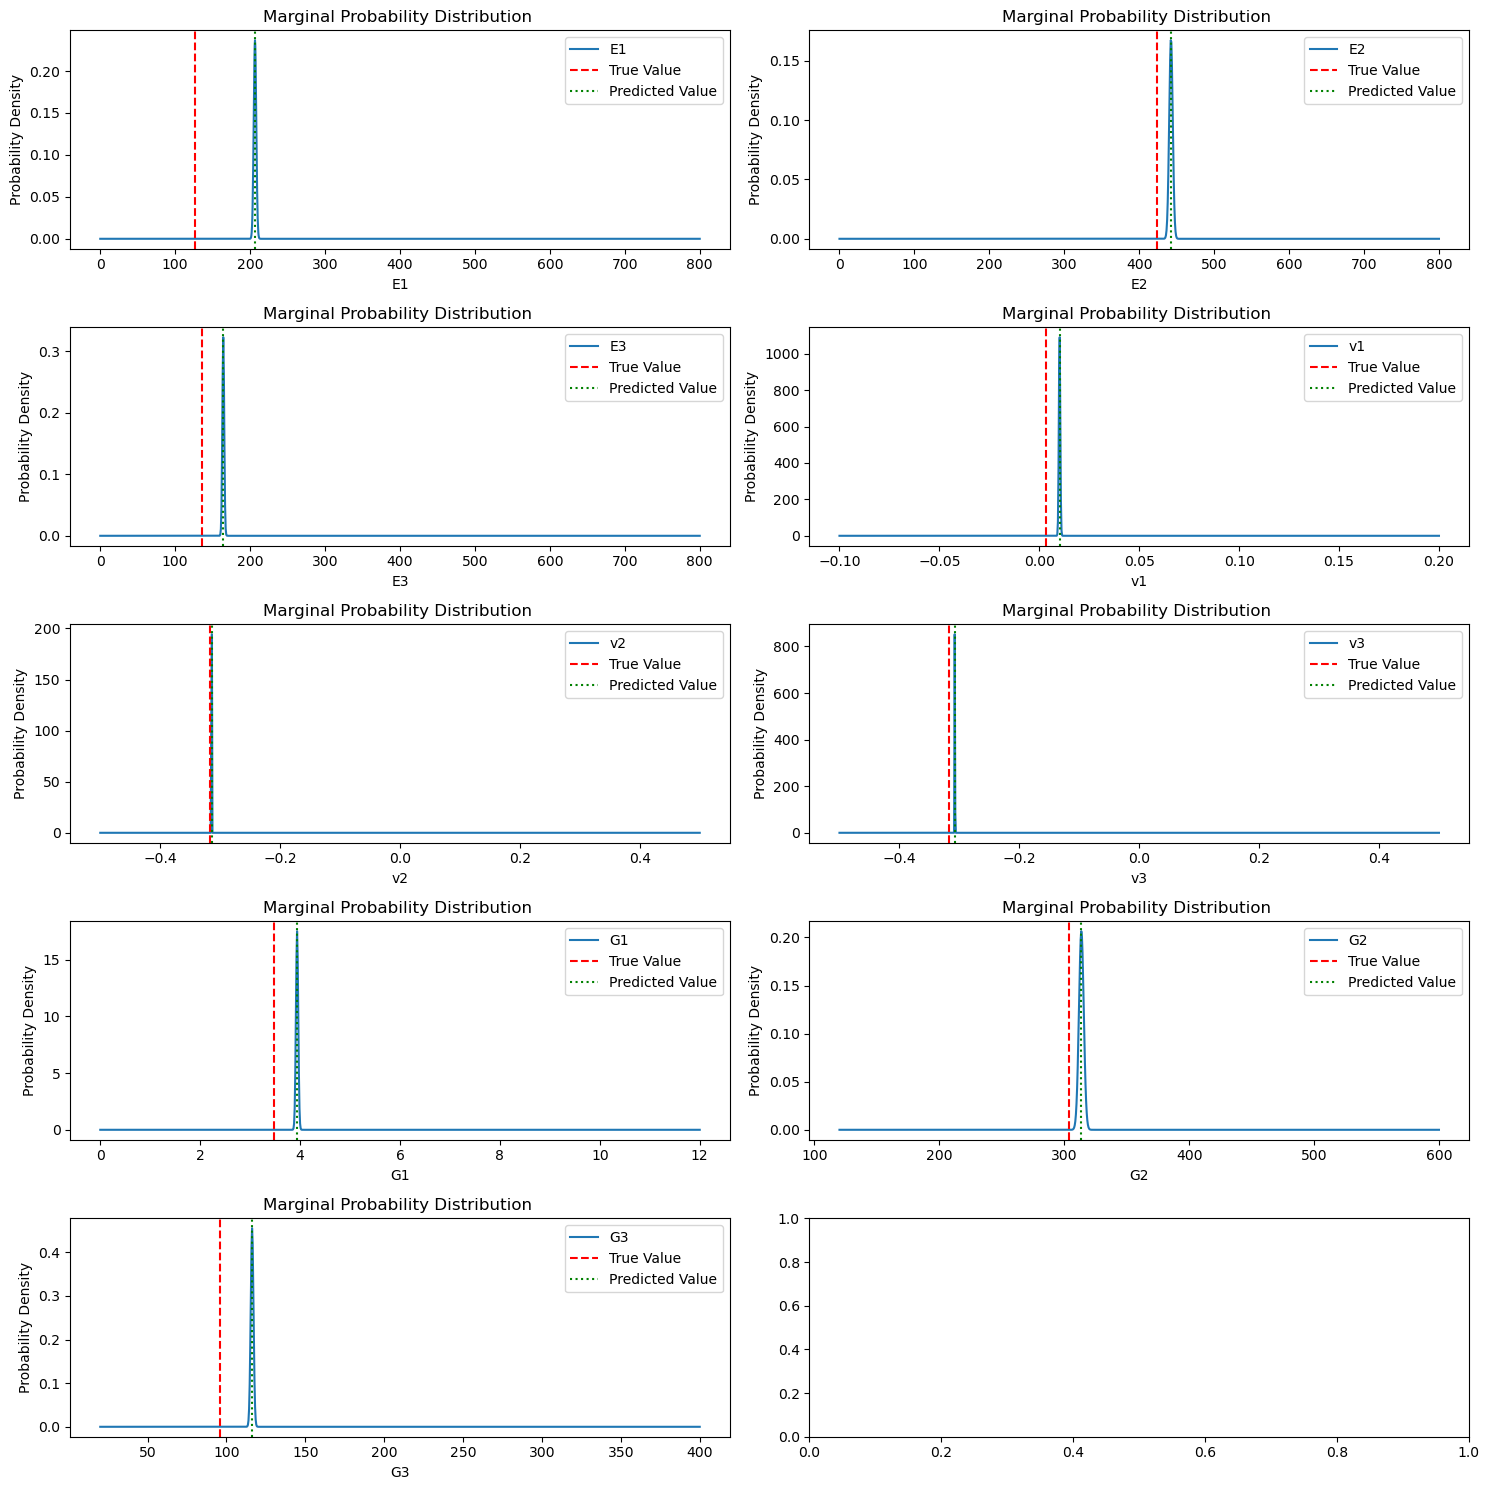

In [39]:
key = ['E1','E2','E3','v1','v2','v3','G1','G2','G3']
std_list = [E1_std,E2_std,E3_std,v1_std,v2_std,v3_std,G1_std,G2_std,G3_std]
x = [np.linspace(0,800,2000),np.linspace(0,800,1000),np.linspace(0,800,1000),
     np.linspace(-0.1,0.2,1000),np.linspace(-0.5,0.5,1000),np.linspace(-0.5,0.5,1000),
     np.linspace(0,12,1000),np.linspace(120,600,1000),np.linspace(20,400,1000)]
distributions = {}
for i,pdf in enumerate(key):
    distributions[key[i]] = norm.pdf(x[i], loc=S[i], scale=std_list[i])
   

# Plotting
fig, axes = plt.subplots(5,2 , figsize=(15, 15))
axes = axes.flatten()

for i, keys in enumerate(key):
    ax = axes[i]
    ax.plot(x[i], distributions[keys], label = f'{key[i]}' )
    ax.axvline(true_values_np[i], color='r', linestyle='--', label='True Value')
    ax.axvline(S[i], color='g', linestyle=':', label='Predicted Value')
    ax.set_title('Marginal Probability Distribution ')
    ax.set_xlabel(f'{key[i]}')
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.tight_layout()
plt.show()

<h1><center><strong><span style="color:red;">End of Forward problem</span></strong></center>